In [110]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, dense_mincut_pool
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

In [111]:
class GATWithMinCutPooling(torch.nn.Module):
    def __init__(
        self,
        num_features,
        num_classes,
        num_hidden=8,
        heads=8,
        dropout=0.6,
        name="GAT",
    ):  
        super(GATWithMinCutPooling, self).__init__()
        self.name = name

        self.conv1 = GATConv(
            in_channels=num_features,
            out_channels=num_hidden,
            heads=heads,
            dropout=dropout,
        )

        self.conv2 = GATConv(
            in_channels=num_hidden * heads,
            out_channels=num_classes,
            heads=1,
            dropout=dropout,
        )
        
        self.num_classes = num_classes
        self.feature_transform = torch.nn.Linear(num_classes, num_features)
        
    def forward(self, data):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = self.conv1(x, data.edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        
        x_dense, mask = to_dense_batch(data.x, data.batch)
        adj_dense = to_dense_adj(data.edge_index, data.batch)

        num_clusters = dataset.num_classes

        transform = torch.nn.Linear(x.size(1), num_clusters)
        s = transform(x)
        s = torch.softmax(s, dim=1)

        x_pool, adj_pool, mincut_loss, ortho_loss = dense_mincut_pool(x_dense, adj_dense, s, mask=mask)
        x_pool = x_pool.squeeze(0)

        return x, x_pool, adj_pool, mincut_loss, ortho_loss

classification_criterion = torch.nn.CrossEntropyLoss()


def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    x_class, x_pool, adj_pool, mincut_loss, ortho_loss = model(data)
    classification_loss = classification_criterion(x_class[data.train_mask], data.y[data.train_mask])
    loss = classification_loss + mincut_loss + ortho_loss
    loss.backward()
    optimizer.step()
    return loss.item(), classification_loss, mincut_loss, ortho_loss

def validate(model, data):
    model.eval()
    with torch.no_grad():
        x_class, x_pool, adj_pool, mincut_loss, ortho_loss = model(data)
        classification_loss = classification_criterion(x_class[data.val_mask], data.y[data.val_mask])
        loss = classification_loss + mincut_loss + ortho_loss
        return loss.item(), classification_loss, mincut_loss, ortho_loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        x_class, x_pool, adj_pool, mincut_loss, ortho_loss = model(data)
        classification_loss = classification_criterion(x_class[data.test_mask], data.y[data.test_mask])
        loss = classification_loss + mincut_loss + ortho_loss
        return loss.item(), classification_loss, mincut_loss, ortho_loss

dataset = Planetoid(root='../Cora', name='Cora')
data = dataset[0]

learning_rates = [0.01, 0.005, 0.001]
dropouts = [0.5, 0.6, 0.7]
best_val_loss = float('inf')
best_hyperparameters = {}

for lr in learning_rates:
    for dropout in dropouts:
        model = GATWithMinCutPooling(num_features=dataset.num_features, num_classes=dataset.num_classes, dropout=dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for epoch in range(50):  
            train_loss, train_class_loss, train_mincut_loss, train_ortho_loss = train(model, data, optimizer)
        val_loss, val_class_loss, val_mincut_loss, val_ortho_loss = validate(model, data)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparameters = {'learning_rate': lr, 'dropout': dropout}
            
print(best_hyperparameters)

{'learning_rate': 0.005, 'dropout': 0.5}


In [112]:
final_model = GATWithMinCutPooling(num_features=dataset.num_features, num_classes=dataset.num_classes, dropout=0.7)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.005)    

for epoch in range(50):
    train_loss, train_class_loss, train_mincut_loss, train_ortho_loss = train(final_model, data, optimizer)
             
test_loss, test_class_loss, test_mincut_loss, test_ortho_loss = test(final_model, data)
print(f"Test Loss: {test_loss}")
print(f'\ttest_class_loss = {test_class_loss}, test_mincut_loss = {test_mincut_loss}, test_ortho_loss = {test_ortho_loss}') 


Test Loss: 0.8450815081596375
	test_class_loss = 0.7326488494873047, test_mincut_loss = -0.9992615580558777, test_ortho_loss = 1.1116942167282104


In [113]:
model = final_model
model.eval()
with torch.no_grad():
    out, x_pool, adj_pool, mincut_loss, ortho_loss = model(data)

edge_index_pool = dense_to_sparse(adj_pool)[0]

pooled_data = Data(x=x_pool, edge_index=edge_index_pool)


In [114]:
pooled_data

Data(x=[7, 1433], edge_index=[2, 42])

In [106]:
import networkx as nx
from sklearn.metrics import accuracy_score
from torch_geometric.utils import to_networkx

# Convert PyG Data objects to NetworkX graphs for analysis
original_graph = to_networkx(data, to_undirected=True)
pooled_graph = to_networkx(pooled_data, to_undirected=True)

print("Original Graph - Nodes:", original_graph.number_of_nodes(), "Edges:", original_graph.number_of_edges())
print("Pooled Graph - Nodes:", pooled_graph.number_of_nodes(), "Edges:", pooled_graph.number_of_edges())

Original Graph - Nodes: 2708 Edges: 5278
Pooled Graph - Nodes: 7 Edges: 21


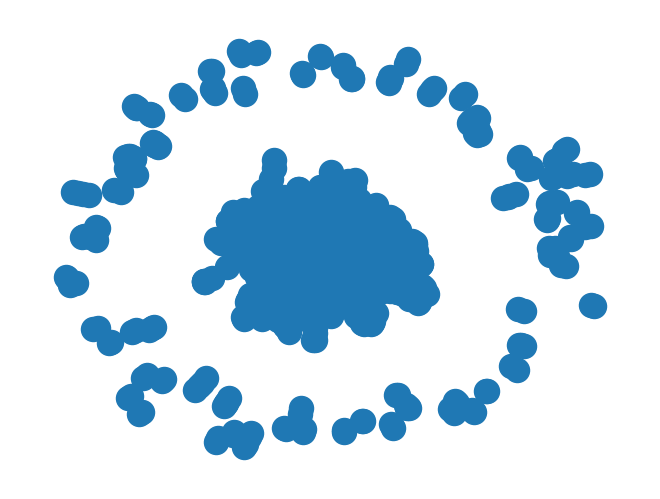

In [107]:
nx.draw(original_graph)


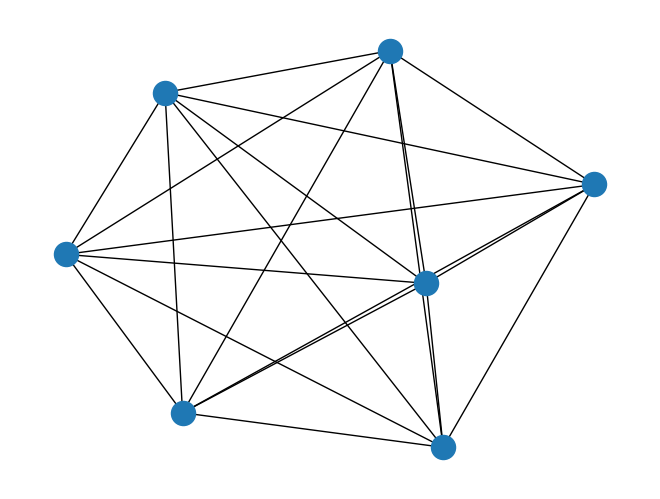

In [108]:
nx.draw(pooled_graph)

In [109]:
pooled_data

Data(x=[7, 1433], edge_index=[2, 42])